# Autotalker Tutorial

- Created by Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- Affiliation: Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- Date of Creation: 01.10.2022

## 1. Setup

### 1.1 Import Libraries

In [255]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
import argparse
import os
import random
import warnings
from copy import deepcopy
from datetime import datetime

import anndata as ad
import matplotlib
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.benchmarking import (compute_avg_cad,
                                     compute_cad,
                                     compute_avg_gcd,
                                     compute_max_lnmi,
                                     compute_per_cell_log_rclisi)
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions)

### 1.2 Configure Paths and Create Directories

In [3]:
# Define paths
gp_data_folder_path = "datasets/gp_data/"
srt_data_folder_path = "datasets/srt_data/"
srt_data_bronze_folder_path = f"{srt_data_folder_path}/bronze"
srt_data_silver_folder_path = f"{srt_data_folder_path}/silver"
srt_data_gold_folder_path = f"{srt_data_folder_path}/gold"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "omnipath_lr_interactions.csv"

# Create required directories
os.makedirs("mlruns", exist_ok=True)
os.makedirs(gp_data_folder_path, exist_ok=True)
os.makedirs(srt_data_bronze_folder_path, exist_ok=True)
os.makedirs(srt_data_silver_folder_path, exist_ok=True)
os.makedirs(srt_data_gold_folder_path, exist_ok=True)

### 1.3 Run Notebook Setup

In [4]:
# Define default matplotlib figure size
matplotlib.rcParams["figure.figsize"] = (5, 5)

In [5]:
# Ignore future warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
# Get time of notebook execution for timestamping saved artefacts
now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

In [175]:
# Set random seed
random_seed = 42

random.seed(random_seed)
np.random.seed(random_seed)

### 1.4 Define Parameters

**Note:** ´edge_batch_size´ is a very important hyperparameter. Training does not work when it is too small because the gradients will be too noisy. If it is too high, you might run into GPU memory constraints.

In [8]:
## Datasets
dataset = "squidpy_seqfish_mouse_organogenesis"
#dataset = "squidpy_slideseqv2_mouse_hippocampus"
#dataset = "vizgen_merfish_mouse_brain"
#dataset = "vizgen_merfish_mouse_liver" 
#dataset = "vizgen_merfish_human_liver_cancer"
#dataset = "10x_xenium_human_breast_cancer"
#dataset = "starmap_plus_mouse_cns"
#dataset = "eel_fish_mouse_brain"
n_neighs = 8 # for spatial neighborhood graph; constrained by GPU memory

## Model
# Neighborhood Gene Expression Aggregation (Node Label Method)
#node_label_method = "self" # does only apply for fully-connected GPs
#node_label_method = "one-hop-sum"
#node_label_method = "one-hop-norm"
node_label_method = "one-hop-attention"

# Trainer
n_epochs = 10
lr = 0.01
weight_decay = 0
edge_val_ratio = 0.1
edge_test_ratio = 0.05
node_val_ratio = 0.1
n_latent_fc_gps = 512 # does only apply for fully-connected GPs
edge_batch_size = 64

## 2. Data

### 2.1 Load & Preprocess Data

#### 2.1.1 Squidpy seqFISH Mouse Organogenesis Dataset

- **Publication:** Lohoff, T. et al. Highly multiplexed spatially resolved gene expression profiling of mouse organogenesis. bioRxiv 2020.11.20.391896 (2020). [doi:10.1101/2020.11.20.391896](https://doi.org/10.1101/2020.11.20.391896)
- **Data Access:** Preprocessed version from squidpy API (original source https://marionilab.cruk.cam.ac.uk/SpatialMouseAtlas/)
- **Summary:**
    - Sagittal tissue section of 8-12 somite-stage mouse embryo
    - 19,416 observations on cell-level with cell-type annotations
    - 351 probed genes

In [9]:
if dataset == "squidpy_seqfish_mouse_organogenesis":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Retrieve adata from squidpy
    adata = sq.datasets.seqfish()
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation (pre-annotated)
    cell_type_key = "celltype_mapped_refined"
        
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

Loading and preprocessing dataset 'squidpy_seqfish_mouse_organogenesis'.


#### 2.1.2 Squidpy Slide-seqV2 Mouse Hippocampus Dataset

- **Publication**: Stickels, R. R. et al. Highly sensitive spatial transcriptomics at near-cellular resolution with Slide-seqV2. Nat. Biotechnol. 39, 313–319 (2021). [doi:10.1038/s41587-020-0739-1](https://doi.org/10.1038/s41587-020-0739-1)
- **Data Access:** Preprocessed version from squidpy API (original source https://singlecell.broadinstitute.org/single_cell/study/SCP815/highly-sensitive-spatial-transcriptomics-at-near-cellular-resolution-with-slide-seqv2)
- **Summary:**
    - Mouse hippocampus puck
    - 41,786 observations on cell-level with cell-type annotations
    - 4,000 probed genes

In [ ]:
if dataset == "squidpy_slideseqv2_mouse_hippocampus":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Retrieve adata from squidpy
    adata = sq.datasets.slideseqv2()
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation (pre-annotated)
    cell_type_key = "cluster"
        
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.3 Vizgen MERFISH Mouse Brain Receptor Dataset

- **Publication:** Vizgen Data Release V1.0. May 2021
- **Data Access:** https://info.vizgen.com/mouse-brain-map?submissionGuid=a66ccb7f-87cf-4c55-83b9-5a2b6c0c12b9
    - Slice 1 Replicate 1
        - cell_by_gene_S1R1.csv
        - cell_metadata_S1R1.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen.html
- **Summary:**
    - Coronal section of mouse brain receptor map
    - 78,329 observations on cell-level without annotations
    - 649 probed genes

In [ ]:
if dataset == "vizgen_merfish_mouse_brain":
    print(f"Loading and preprocessing dataset '{dataset}'.")

    # Read adata from files
    merfish_dir = f"{srt_data_bronze_folder_path}/merfish/"
    adata = sq.read.vizgen(path=merfish_dir,
                           counts_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_by_gene_S1R1.csv",
                           meta_file="datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv")

    # Preprocess as per squidpy vignette
    adata.var_names.unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.histplot(adata.obs["total_counts"],
                 kde=False,
                 ax=axs[0])
    sns.histplot(adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
                 kde=False,
                 bins=40,
                 ax=axs[1])
    sns.histplot(adata.obs["n_genes_by_counts"],
                 kde=False,
                 bins=60,
                 ax=axs[2])
    sns.histplot(adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
                 kde=False,
                 bins=60,
                 ax=axs[3])
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    cell_type_key = "leiden"
    sc.pl.umap(adata,
               color=["total_counts", "n_genes_by_counts", "leiden",])
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.4 Vizgen MERFISH Mouse Liver Dataset

- **Publication**: Vizgen MERFISH Mouse Liver Map January 2022
- **Data Access:** https://info.vizgen.com/mouse-liver-access
    - Animal 1 replicate 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_vizgen_mouse_liver.html
- **Summary:**
    - Liver tissue section of mouse liver map
    - 367,335 observations on cell-level without annotations
    - 385 probed genes

In [ ]:
if dataset == "vizgen_merfish_mouse_liver":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from files
    merfish_dir = f"{srt_data_bronze_folder_path}/merfish/"
    adata = sq.read.vizgen(merfish_dir,
                           counts_file="Liver1Slice1_cell_by_gene.csv",
                           meta_file="Liver1Slice1_cell_metadata.csv")
    
    # Preprocess as per squidpy vignette
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    sc.tl.pca(adata, svd_solver="arpack")
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=1.5)
    
    sc.set_figure_params(figsize=(10,10))
    sc.pl.umap(adata, color=["leiden"], size=5)
    
    gene_panel = "https://static-content.springer.com/esm/art%3A10.1038%2Fs41421-021-00266-1/MediaObjects/41421_2021_266_MOESM1_ESM.xlsx"
    df_ref_panel_ini = pd.read_excel(gene_panel, index_col=0)
    df_ref_panel = df_ref_panel_ini.iloc[1:,:1]
    df_ref_panel.index.name = None
    df_ref_panel.columns = ["Function"]
    
    # Assign marker gene metadata using reference dataset
    marker_genes = df_ref_panel[df_ref_panel["Function"].str.contains("marker")].index.tolist()
    
    meta_gene = deepcopy(adata.var)
    common_marker_genes = list(set(meta_gene.index.tolist()).intersection(marker_genes))
    meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
    meta_gene["Markers"] = meta_gene["Markers"].apply(lambda x: "N.A." if "marker" not in str(x) else x)
    meta_gene["Markers"].value_counts()
    
    ser_counts = adata.obs["leiden"].value_counts()
    ser_counts.name = "cell counts"
    meta_leiden = pd.DataFrame(ser_counts)
    
    cat_name = "leiden"
    sig_leiden = pd.DataFrame(columns=adata.var_names, index=adata.obs[cat_name].cat.categories)
    for clust in adata.obs[cat_name].cat.categories:
        sig_leiden.loc[clust] = adata[adata.obs[cat_name].isin([clust]),:].X.mean(0)
    sig_leiden = sig_leiden.transpose()
    leiden_clusters = ["Leiden-" + str(x) for x in sig_leiden.columns.tolist()]
    sig_leiden.columns = leiden_clusters
    meta_leiden.index = sig_leiden.columns.tolist()
    meta_leiden["leiden"] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())
    
    meta_gene = pd.DataFrame(index=sig_leiden.index.tolist())
    meta_gene["info"] = pd.Series("", index=meta_gene.index.tolist())
    meta_gene["Markers"] = pd.Series("N.A.", index=sig_leiden.index.tolist())
    meta_gene.loc[common_marker_genes, "Markers"] = df_ref_panel.loc[common_marker_genes, "Function"]
    
    meta_leiden["Cell_Type"] = pd.Series("N.A.", index=meta_leiden.index.tolist())
    num_top_genes = 30
    for inst_cluster in sig_leiden.columns.tolist():
        top_genes = sig_leiden[inst_cluster].sort_values(ascending=False).index.tolist()[:num_top_genes]
    
        inst_ser = meta_gene.loc[top_genes, "Markers"]
        inst_ser = inst_ser[inst_ser != "N.A."]
        ser_counts = inst_ser.value_counts()
      
        max_count = ser_counts.max()
      
        max_cat = "_".join(sorted(ser_counts[ser_counts == max_count].index.tolist()))
        max_cat = max_cat.replace(" marker", "").replace(" ", "-")
      
        print(inst_cluster, max_cat)
        meta_leiden.loc[inst_cluster, "Cell_Type"] = max_cat
    
    # Rename clusters
    meta_leiden["name"] = meta_leiden.apply(lambda x: x["Cell_Type"] + "_" + x["leiden"] , axis=1)
    leiden_names = meta_leiden["name"].values.tolist()
    meta_leiden.index = leiden_names
    
    # Transfer cell type labels to single cells
    leiden_to_cell_type = deepcopy(meta_leiden)
    leiden_to_cell_type.set_index("leiden", inplace=True)
    leiden_to_cell_type.index.name = None
    
    adata.obs["Cell_Type"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "Cell_Type"])
    adata.obs["Cluster"] = adata.obs["leiden"].apply(lambda x: leiden_to_cell_type.loc["Leiden-" + str(x), "name"])
    cell_type_key = "Cell_Type"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.5 Vizgen MERFISH Human Liver Cancer Dataset

- **Publication:** Vizgen MERFISH FFPE Human Immuno-oncology Data Set,  May 2022
- **Data Access:** https://info.vizgen.com/ffpe-showcase?submissionGuid=bbe0d6ca-92ad-4257-bdcd-cbc6dee8219b
    - Liver cancer 1
        - cell_by_gene.csv
        - cell_metadata.csv
- **Summary:**
    - FFPE tissue section of human liver cancer
    - 480,592 observations on cell-level without annotations
    - 500 probed genes

In [ ]:
if dataset == "vizgen_merfish_human_liver_cancer":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read counts and remove blank genes
    vizgen_dir = f"{srt_data_bronze_folder_path}/merfish/"
    adata = ad.read_text(vizgen_dir + "HumanLiverCancerPatient1_cell_by_gene.csv" ,delimiter=",", first_column_names=True)
    blank_genes = np.array(["Blank" in v for v in adata.var_names])
    adata.obsm["blank_genes"] = pd.DataFrame(adata[:, blank_genes].X.copy(), columns=adata.var_names[blank_genes], index=adata.obs_names)
    adata = adata[:, ~blank_genes].copy()
    adata.X = sp.csr_matrix(adata.X)
    
    # Read metadata and align index for join
    metadata = pd.read_csv(vizgen_dir + "HumanLiverCancerPatient1_cell_metadata.csv", header=0, index_col=0)
    metadata.sort_index(inplace=True)
    metadata.index = metadata.index.astype("str")
    
    # Join counts with obs and store spatial coordinates
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["center_x", "center_y"]].values
    adata.obs.drop(columns=["center_x", "center_y"], inplace=True)
    
    # Preprocess
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=50)
    sc.pp.filter_genes(adata, min_cells=10)
    
    # Store raw counts in `layers`
    adata.layers["counts"] = adata.X.copy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    sc.pl.umap(adata,
               color=["total_counts", "n_genes_by_counts", "leiden"])
    cell_type_key = "leiden"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.6 10x Genomics Xenium Human Breast Cancer Tumor Microenvironment Dataset

- **Publication:** Janesick, A. et al. High resolution mapping of the breast cancer tumor microenvironment using integrated single cell, spatial and in situ analysis of FFPE tissue. bioRxiv 2022.10.06.510405 (2022). [doi:10.1101/2022.10.06.510405](https://doi.org/10.1101/2022.10.06.510405)
- **Data Access:** https://www.10xgenomics.com/products/xenium-in-situ/preview-dataset-human-breast
    - Feature-cell matrix (HDF5)
    - Cell summary file (CSV) -> unpack with ```gzip -d Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv.gz```
- **Preprocessing Vignette:** https://squidpy.readthedocs.io/en/latest/external_tutorials/tutorial_xenium.html
- **Summary**:
    - FFPE tissue section of human breast cancer
    - 164,079 observations on cell-level without annotations
    - 313 probed genes

In [ ]:
if dataset == "10x_xenium_human_breast_cancer":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from file and add metadata
    xenium_dir = f"{srt_data_bronze_folder_path}/xenium/"
    adata = sc.read_10x_h5(filename=xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_Rep1_cell_feature_matrix.h5")
    metadata = pd.read_csv(xenium_dir + "Xenium_FFPE_Human_Breast_Cancer_Rep1_cells.csv")
    metadata.set_index(adata.obs_names, inplace=True)
    adata.obs = metadata.copy()
    
    # Preprocess as per squidpy vignette
    adata.var_names_make_unique()
    adata.var["mt"] = adata.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"],percent_top=(50, 100, 200, 300), inplace=True)
    sc.pp.filter_cells(adata, min_counts=10)
    sc.pp.filter_genes(adata, min_cells=5)
    
    # Store counts in `layers` and spatial coords in `obsm`
    adata.layers["counts"] = adata.X.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    
    # Store data to disk
    adata.write(f"{srt_data_silver_folder_path}/{dataset}.h5ad")
    
    # Determine cell annotation as per squidpy vignette
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.tl.leiden(adata)
    cell_type_key = "leiden"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.7 STARmap PLUS Mouse Central Nervous System Dataset

- **Publication:** Shi, H. et al. Spatial Atlas of the Mouse Central Nervous System at Molecular Resolution. bioRxiv 2022.06.20.496914 (2022). [doi:10.1101/2022.06.20.496914](https://doi.org/10.1101/2022.06.20.496914)
- **Data Access:** https://singlecell.broadinstitute.org/single_cell/study/SCP1830
    - Sagittal 1 (Slice 3)
        - sagittal1_spatial.csv
        - sagittal1raw_expression_pd.csv
- **Summary:**
    - Sagittal section of mouse brain
    - 91,246 observations on cell-level with cell-type annotations
    - 1022 genes

In [ ]:
if dataset == "starmap_plus_mouse_cns":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read counts and metadata and change format
    starmap_plus_dir = f"{srt_data_bronze_folder_path}/starmap_plus/"
    metadata = pd.read_csv(starmap_plus_dir + "sagittal1_spatial.csv", skiprows=[1])
    counts = pd.read_csv(starmap_plus_dir + "sagittal1raw_expression_pd.csv")
    counts.set_index("GENE", inplace=True)
    metadata.set_index("NAME", inplace=True)
    counts = counts.T
    
    # Merge counts with metadata and store counts in `layers` and spatial coords in `obsm`
    adata = ad.AnnData(counts, dtype=np.float32)
    adata.obs = pd.merge(adata.obs, metadata, how="left", left_index=True, right_index=True)
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values / 1000 # smaller scale for plotting with squidpy
    adata.obs.drop(columns=["X", "Y", "Z"], inplace=True)
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    cell_type_key = "Maintype_Symbol"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

#### 2.1.8 EEL FISH Mouse Brain Dataset

- **Publication:** Borm, L. E. et al. Scalable in situ single-cell profiling by electrophoretic capture of mRNA using EEL FISH. Nat. Biotechnol. (2022) [doi:10.1038/s41587-022-01455-3](https://doi.org/10.1038/s41587-022-01455-3)
- **Data Accress:** https://figshare.com/articles/dataset/EEL_Mouse_440_genes_single_cell_data/20310771
    - LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad
- **Summary:**
    - Sagittal mouse brain section
    - 127,591 observations on cell-level with cluster annotations 
    - 440 genes

In [ ]:
if dataset == "eel_fish_mouse_brain":
    print(f"Loading and preprocessing dataset '{dataset}'.")
    
    # Read adata from file
    eel_fish_dir = f"{srt_data_bronze_folder_path}/eel_fish/"
    adata = sc.read_h5ad(eel_fish_dir + "LBEXP20210718_EEL_Mouse_448_2_20220512.h5ad")
    
    # Store counts in `layers` and spatial coords in `obsm`
    adata.obsm["spatial"] = adata.obs[["X", "Y"]].values # smaller scale for plotting with squidpy
    adata.obs.drop(columns=["X", "Y", "X_um", "Y_um"], inplace=True)
    adata.layers["counts"] = adata.X.copy()
    
    # Determine cell annotation
    cell_type_key = "Clusters"
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata, coord_type="generic", spatial_key="spatial", n_neighs=n_neighs)
    
    # Store data to disk
    adata.write(f"{srt_data_gold_folder_path}/{dataset}.h5ad")
    
else:
    print("No action taken.")

### 2.2 Explore Data

Using dataset squidpy_seqfish_mouse_organogenesis.
Number of nodes (cells): 19416
Number of node features (genes): 351
Average number of edges per node: 8.0
Number of total edges: 78058
--------------------


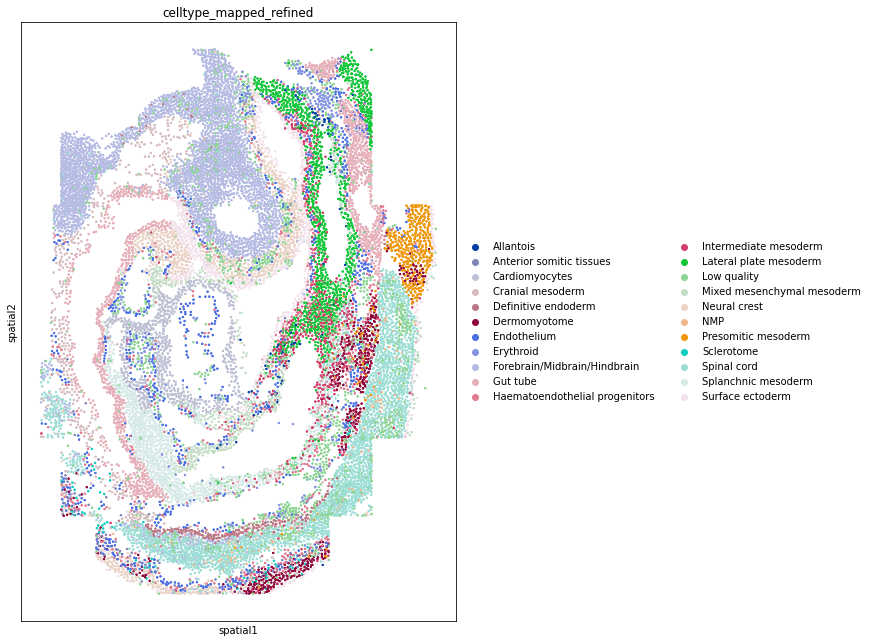

In [10]:
print(f"Using dataset {dataset}.")
print(f"Number of nodes (cells): {adata.layers['counts'].shape[0]}")
print(f"Number of node features (genes): {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(adata.obsp['spatial_connectivities'].sum(axis=0).mean(), 2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(sp.triu(adata.obsp['spatial_connectivities'], k=1).sum())
print(f"Number of total edges: {n_edges}", sep="")
print("--------------------")
# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata, color=cell_type_key, shape=None, figsize=(12, 12))

## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [ ]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")

### 3.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=int(n_latent_fc_gps/2),
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask))

In [ ]:
experiment = mlflow.set_experiment("autotalker_fc_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_fc_gps_{current_time}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_fc_gps_{current_time}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad")

### 3.3. Store Latent Gene Programs & Generate UMAP

In [ ]:
# Store autotalker latent space
latent = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_fc_gps"] = latent

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_fc_gps")
sc.tl.umap(adata, min_dist=0.3)

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 OmniPath Ligand Receptor CCI Gene Programs

#### 4.1.1 Create OmniPath CCI Gene Program Mask

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_omnipath_gp_targets",
    gp_sources_varm_key="autotalker_omnipath_gp_sources",
    gp_names_uns_key="autotalker_omnipath_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
# Summarize gene programs
print(f"Number of gene programs: {len(adata.uns['autotalker_omnipath_gp_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_omnipath_gp_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_omnipath_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_omnipath_gp_sources'].sum()}.")

In [ ]:
# Determine number of hidden layers
omnipath_gp_targets_mask = torch.tensor(adata.varm["autotalker_omnipath_gp_targets"].T, dtype=torch.float32)
omnipath_gp_sources_mask = torch.tensor(adata.varm["autotalker_omnipath_gp_sources"].T, dtype=torch.float32)
omnipath_gp_mask = torch.cat((omnipath_gp_targets_mask, omnipath_gp_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {omnipath_gp_mask.shape}.")
omnipath_gp_n_hidden_encoder = int(omnipath_gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {omnipath_gp_n_hidden_encoder}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_omnipath_gp_targets",
                   gp_sources_mask_key="autotalker_omnipath_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=omnipath_gp_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_omnipath_gps_{current_time}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_omnipath_gps_{current_time}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad")

#### 4.1.3 Store Latent Gene Programs & Generate UMAP

In [ ]:
# Store autotalker latent space
latent = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_omnipath_gps"] = latent
model.adata.obsm["latent_autotalker_omnipath_gps"] = latent

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_omnipath_gps")
sc.tl.umap(adata, min_dist=0.3)

### 4.2 NicheNet Ligand Target Gene CCI Gene Programs

#### 4.2.1 Create NicheNet CCI Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_nichenet_gp_targets",
    gp_sources_varm_key="autotalker_nichenet_gp_sources",
    gp_names_uns_key="autotalker_nichenet_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
# Summarize gene programs
print(f"Number of gene programs: {len(adata.uns['autotalker_nichenet_gp_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_nichenet_gp_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_nichenet_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_nichenet_gp_sources'].sum()}.")

In [ ]:
# Determine number of hidden layers
nichenet_gp_targets_mask = torch.tensor(adata.varm["autotalker_nichenet_gp_targets"].T, dtype=torch.float32)
nichenet_gp_sources_mask = torch.tensor(adata.varm["autotalker_nichenet_gp_sources"].T, dtype=torch.float32)
nichenet_gp_mask = torch.cat((nichenet_gp_targets_mask, nichenet_gp_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {nichenet_gp_mask.shape}.")
nichenet_gp_n_hidden_encoder = int(nichenet_gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {nichenet_gp_n_hidden_encoder}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_nichenet_gp_targets",
                   gp_sources_mask_key="autotalker_nichenet_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=nichenet_gp_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_nichenet_gps_{current_time}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_nichenet_gps_{current_time}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad")

#### 4.2.3 Store Latent Gene Programs & Generate UMAP

In [ ]:
# Store autotalker latent space
latent = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_nichenet_gps"] = latent
model.adata.obsm["latent_autotalker_nichenet_gps"] = latent

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_nichenet_gps")
sc.tl.umap(adata, min_dist=0.3)

### 4.3 MEBOCOST Metabolite Enzyme Sensor CCI Gene Programs

#### 4.3.1 Create MEBOCOST CCI Gene Program Mask

In [ ]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(species="mouse")

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=mebocost_gp_dict,
    genes_uppercase=False,
    gp_targets_varm_key="autotalker_mebocost_gp_targets",
    gp_sources_varm_key="autotalker_mebocost_gp_sources",
    gp_names_uns_key="autotalker_mebocost_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
# Summarize gene programs
print(f"Number of gene programs: {len(adata.uns['autotalker_mebocost_gp_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_mebocost_gp_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_mebocost_gp_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_mebocost_gp_sources'].sum()}.")

In [ ]:
# Determine number of hidden layers
mebocost_gp_targets_mask = torch.tensor(adata.varm["autotalker_mebocost_gp_targets"].T, dtype=torch.float32)
mebocost_gp_sources_mask = torch.tensor(adata.varm["autotalker_mebocost_gp_sources"].T, dtype=torch.float32)
mebocost_gp_mask = torch.cat((mebocost_gp_targets_mask, mebocost_gp_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {mebocost_gp_mask.shape}.")
mebocost_gp_n_hidden_encoder = int(mebocost_gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {mebocost_gp_n_hidden_encoder}.")

#### 4.3.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_mebocost_gp_targets",
                   gp_sources_mask_key="autotalker_mebocost_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=mebocost_gp_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_mebocost_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_mebocost_gps_{current_time}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_mebocost_gps_{current_time}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad")

#### 4.3.3 Store Latent Gene Programs & Generate UMAP

In [ ]:
# Store autotalker latent space
latent = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_mebocost_gps"] = latent
model.adata.obsm["latent_autotalker_mebocost_gps"] = latent

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_mebocost_gps")
sc.tl.umap(adata, min_dist=0.3)

### 4.4 Combined Prior Knowledge CCI Gene Programs

#### 4.4.1 Create Combined Prior Knowledge CCI Gene Program Mask

In [10]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [11]:
list(nichenet_gp_dict.keys())[:5]

['CXCL1_ligand_targetgenes_GP',
 'CXCL2_ligand_targetgenes_GP',
 'CXCL3_ligand_targetgenes_GP',
 'CXCL5_ligand_targetgenes_GP',
 'PPBP_ligand_targetgenes_GP']

In [12]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [13]:
list(omnipath_gp_dict.keys())[:5]

['BDNF_ligand_receptor_GP',
 'EPOR_ligand_receptor_GP',
 'FYN_ligand_receptor_GP',
 'AVP_ligand_receptor_GP',
 'NGF_ligand_receptor_GP']

In [14]:
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    species="mouse",
    genes_uppercase=True)

In [15]:
list(mebocost_gp_dict.keys())[:5]

['Deoxyuridine_metabolite_enzyme_sensor_GP',
 'Deoxycytidine_metabolite_enzyme_sensor_GP',
 '3-Methoxytyramine_metabolite_enzyme_sensor_GP',
 'Biotin_metabolite_enzyme_sensor_GP',
 'Androsterone_metabolite_enzyme_sensor_GP']

In [16]:
# Combine gene programs into one dictionary
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [112]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_combined_gp_targets",
    gp_sources_varm_key="autotalker_combined_gp_sources",
    gp_names_uns_key="autotalker_combined_gp_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [18]:
# Summarize gene programs
print(f"Number of gene programs: {len(adata.uns['autotalker_combined_gp_names'])}.")
print(f"Example gene programs: {random.sample(adata.uns['autotalker_combined_gp_names'], 5)}.")
print(f"Number of total gene program target genes: {adata.varm['autotalker_combined_gp_targets'].sum()}.")
print(f"Number of total gene program source genes: {adata.varm['autotalker_combined_gp_sources'].sum()}.")

Number of gene programs: 802.
Example gene programs: ['CDHR2_ligand_targetgenes_GP', 'IL1A_ligand_targetgenes_GP', 'CCL14_ligand_targetgenes_GP', 'CER1_ligand_receptor_GP', 'PTHLH_ligand_targetgenes_GP'].
Number of total gene program target genes: 68295.
Number of total gene program source genes: 135.


In [19]:
# Determine number of hidden layers
combined_gp_targets_mask = torch.tensor(adata.varm["autotalker_combined_gp_targets"].T, dtype=torch.float32)
combined_gp_sources_mask = torch.tensor(adata.varm["autotalker_combined_gp_sources"].T, dtype=torch.float32)
combined_gp_mask = torch.cat((combined_gp_targets_mask, combined_gp_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {combined_gp_mask.shape}.")
combined_gp_n_hidden_encoder = int(combined_gp_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {combined_gp_n_hidden_encoder}.")

Gene program mask shape (gene programs x nodes): torch.Size([802, 702]).
Number of hidden layers in the encoder: 401.


#### 4.4.2 Initialize, Train & Save Model

In [20]:
# Pass masks either trough ´gp_targets_mask_key´ and ´gp_sources_mask_key´ of adata or directly
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_combined_gp_targets",
                   gp_sources_mask_key="autotalker_combined_gp_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=combined_gp_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-attention
GCN ENCODER -> n_input: 351, n_hidden: 401, n_latent: 802, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 0, n_output: 702


In [21]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 66351
Number of validation edges: 7805
Number of test edges: 3902

--- MODEL TRAINING ---
Epoch 1/10 |██------------------| 10.0% val_auroc_score: 0.9337; val_auprc_score: 0.9029; val_best_acc_score: 0.7495; val_best_f1_score: 0.7997; train_edge_recon_loss: 2.4656; train_kl_loss: 0.3517; train_gene_expr_recon_loss: 486.7652; train_loss: 489.5824; val_edge_recon_loss: 1.6030; val_kl_loss: 0.4343; val_gene_expr_recon_loss: 476.4109; val_loss: 478.4482
Epoch 2/10 |████----------------| 20.0% val_auroc_score: 0.9353; val_auprc_score: 0.9042; val_best_acc_score: 0.7840; val_best_f1_score: 0.8222; train_edge_recon_loss: 1.5020; train_kl_loss: 0.4773; train_gene_expr_recon_loss: 475.8529; train_loss: 477.8322; val_edge_recon_loss: 1.4629; val_kl_loss: 0.5281; val_gene_expr_recon_loss: 475.2261; val_loss: 477.2172
Epoch 3/10 |██████--------------| 30.0% val_auroc_score: 0.942

In [25]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_time}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

In [94]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_time}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-attention
GCN ENCODER -> n_input: 351, n_hidden: 401, n_latent: 802, n_addon_latent: 0, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 802, n_addon_input: 0, n_output: 702


#### 4.4.3 Store Latent Gene Programs & Generate UMAP

In [27]:
# Store autotalker latent space
latent = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_combined_gps"] = latent
model.adata.obsm["latent_autotalker_combined_gps"] = latent

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_combined_gps")
sc.tl.umap(adata, min_dist=0.3)

### 4.5 Learn New CCI Gene Programs

In [ ]:
model = Autotalker.load(dir_path=f"./model_artefacts/{dataset}/autotalker_combined_gps_{current_time}",
                        adata=None,
                        adata_file_name=f"{dataset}.h5ad",
                        n_addon_gps=10,
                        freeze_non_addon_weights=True)

In [ ]:
experiment = mlflow.set_experiment("autotalker_denovo_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=n_epochs,
            lr=lr,
            weight_decay=weight_decay,
            edge_val_ratio=edge_val_ratio,
            edge_test_ratio=edge_test_ratio,
            node_val_ratio=node_val_ratio,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id,
            verbose=True)

In [ ]:
model.save(dir_path=f"./model_artefacts/{dataset}/autotalker_denovo_gps_{current_time}",
           overwrite=True,
           save_adata=True,
           adata_file_name=f"{dataset}.h5ad")

## 5. Benchmarking

### 5.1 Graph Connectivity Distance (GCD)

Measures the edge preservation in the latent space vs the physical space.

In [ ]:
avg_gcd_list = []

avg_gcd_list.append(compute_avg_gcd(adata=adata,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_combined_gps",
                          seed=random_state))

In [ ]:
plt.scatter(avg_gcd_list)

In [ ]:
avg_gcd = compute_avg_gcd(adata=adata,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_omnipath_gps",
                          seed=random_state)
print("Average graph connectivity distance:", avg_gcd)

### 5.2 Leiden Normalized Mutual Info (LNMI)

Measures the preservation of spatial organization by comparing cluster overlaps between the latent space and physical space.

In [ ]:
max_lnmi = compute_max_lnmi(adata=adata,
                            spatial_key="spatial",
                            latent_key="latent_autotalker_fc_gps",
                            seed=random_state,
                            visualize_leiden_clustering=True)
print(f"Maximum Leiden Normalized Mutual Info: {max_lnmi}.")

### 5.3 Cell-type Affinity Distance (CAD)

Measures preservation of cell-cell contact maps, that means cell-type enrichments in a cell’s neighborhood across all cells, in latent space vs physical space.

In [ ]:
avg_cad = compute_avg_cad(adata=adata,
                          cell_type_key=cell_type_key,
                          spatial_key="spatial",
                          latent_key="latent_autotalker_fc_gps",
                          seed=random_state)
print("Average cell-type affinity distance:", avg_cad)

In [ ]:
cad = compute_cad(adata=adata,
                  cell_type_key=cell_type_key,
                  spatial_key="spatial",
                  latent_key="latent_autotalker_fc_gps",
                  n_neighbors=15,
                  seed=random_state,
                  visualize_ccc_maps=True)
print("Cell-type affinity distance:", cad)

### 5.4 Relative Cell-type Local Inverse Simpson's Index (RCLISI)

Measures preservation of spatial cell-type heterogeneity in latent space vs physical space.

In [ ]:
per_cell_log_rclisi_df = compute_per_cell_log_rclisi(adata=adata,
                                                     cell_type_key=cell_type_key,
                                                     spatial_key="spatial",
                                                     latent_key="latent_autotalker_fc_gps",
                                                     n_neighbors=15,
                                                     seed=random_state)

In [ ]:
sns.displot(per_cell_log_rclisi_df, x="log_rclisi", kind="kde", bw_adjust=2, height=3, aspect=10)

### 5.5 Gene Expression Reconstruction (GER)

## 6. Analysis

In [28]:
latent_key = "latent_autotalker_combined_gps"
gp_key = "autotalker_combined_gp_names"
gps = adata.uns[gp_key]

### 6.1 Cell-type Annotations in Physical and Latent Space

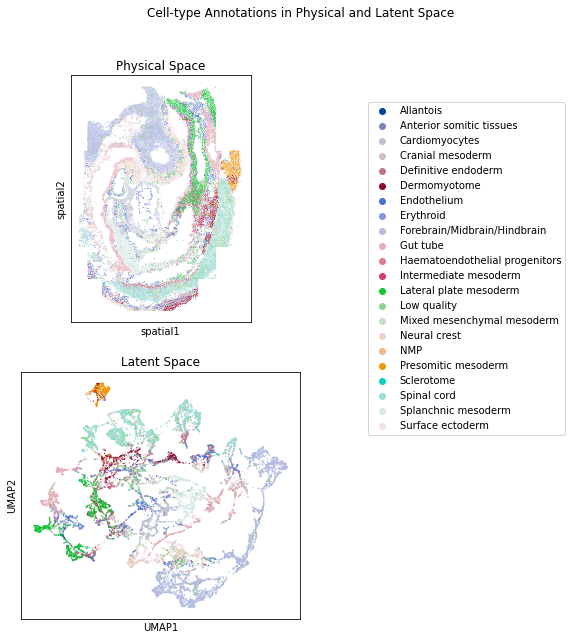

In [29]:
# Create subplot of cell-type annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
title = fig.suptitle("Cell-type Annotations in Physical and Latent Space", x=0.9, y=0.975)
sc.pl.spatial(adata=adata,
              color=[cell_type_key],
              spot_size=0.03,
              title="Physical Space",
              ax=axs[0],
              show=False)
sc.pl.umap(adata=adata,
           color=[cell_type_key],
           title="Latent Space",
           ax=axs[1],
           show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.65, 0.85))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/cell_type_annotations_in_physical_and_latent_space_{current_time}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

### 6.2 Latent Leiden Cluster Annotations in Latent and Physical Space

In [30]:
model.compute_latent_graph_connectivities(adata=adata,
                                          latent_key=latent_key,
                                          n_neighbors=8,
                                          mode="knn",
                                          seed=42)

In [31]:
# Compute latent Leiden clustering
resolution = 0.3

sc.tl.leiden(adata=adata,
             resolution=resolution,
             random_state=random_state,
             key_added=f"latent_leiden_{str(resolution)}",
             adjacency=adata.obsp["latent_connectivities"])

# Compute UMAP for latent Leiden clusters
sc.pp.neighbors(adata=adata, use_rep=latent_key)
sc.tl.umap(adata=adata, min_dist=0.3)

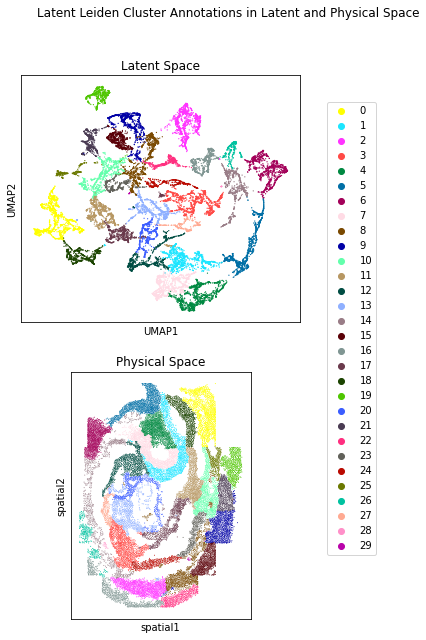

In [32]:
# Create subplot of latent Leiden cluster annotations in physical and latent space
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5, 10))
title = fig.suptitle("Latent Leiden Cluster Annotations in Latent and Physical Space", x=0.7, y=0.975)
sc.pl.umap(adata=adata,
           color=[f"latent_leiden_{str(resolution)}"],
           color_map="magma",
           title=f"Latent Space",
           ax=axs[0],
           show=False)
sc.pl.spatial(adata=adata,
              color=[f"latent_leiden_{str(resolution)}"],
              color_map="magma",
              spot_size=0.03,
              title=f"Physical Space",
              ax=axs[1],
              show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, bbox_to_anchor=(1.125, 0.85))
axs[0].get_legend().remove()
axs[1].get_legend().remove()

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/latent_leiden_cluster_annotations_in_latent_and_physical_space_{current_time}.png",
            bbox_extra_artists=(lgd, title),
            bbox_inches="tight")
plt.show()

In [ ]:
# Visualize cell-level annotated data in physical space
sq.pl.spatial_scatter(adata,
                      color=cell_type_key,
                      groups=["Endothelium", "Erythroid"],
                      shape=None,
                      figsize=(6, 6))

### 6.3 Gene Program Enrichments

#### 6.3.1 Cell-type Gene Program Enrichments

In [197]:
gp_enrichment_scores_key = "autotalker_combined_gp_cell_type_gp_enrichment_scores"
n_top_up_gps = 6
n_top_down_gps = 6

##### 6.3.1.1 Explore All GPs

In [205]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_gps = model.compute_gp_enrichment_scores(cat_key=cell_type_key,
                                             gp_key=gp_key,
                                             adata=adata,
                                             comparison_cats="rest",
                                             n_sample=10000,
                                             selected_gps=None,
                                             key_added=gp_enrichment_scores_key,
                                             n_top_up_gps_retrieved=n_top_up_gps,
                                             n_top_down_gps_retrieved=n_top_down_gps,
                                             seed=random_state)

In [203]:
# Display top upregulated gene programs
adata.uns[gp_enrichment_scores_key][:n_top_up_gps]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,Erythroid,EPOR_ligand_receptor_GP,0.997782,0.002218,6.108752
1,Erythroid,Riboflavin_metabolite_enzyme_sensor_GP,0.996752,0.003248,5.726540
2,Endothelium,CDH5_ligand_targetgenes_GP,0.996216,0.003784,5.573196
3,Erythroid,5-Aminolevulinic acid_metabolite_enzyme_sensor_GP,0.996200,0.003800,5.568862
4,Cardiomyocytes,NRP1_ligand_receptor_GP,0.995951,0.004049,5.505207
5,Cardiomyocytes,BMP7_ligand_receptor_GP,0.995377,0.004623,5.372150


In [204]:
# Display top downregulated gene programs
adata.uns[gp_enrichment_scores_key][-n_top_down_gps:][::-1]

,category,gene_program,p_h0,p_h1,log_bayes_factor
17643,Endothelium,PECAM1_ligand_receptor_GP,0.006644,0.993356,-5.007450
17642,Cardiomyocytes,Dihydrotestosterone_metabolite_enzyme_sensor_GP,0.009261,0.990739,-4.672589
17641,Erythroid,LEFTY2_ligand_targetgenes_GP,0.009278,0.990722,-4.670832
17640,Erythroid,Succinic acid_metabolite_enzyme_sensor_GP,0.009761,0.990239,-4.619556
17639,Endothelium,IL27_ligand_targetgenes_GP,0.010621,0.989379,-4.534225
17638,Cardiomyocytes,CTF1_ligand_targetgenes_GP,0.017715,0.982285,-4.015495


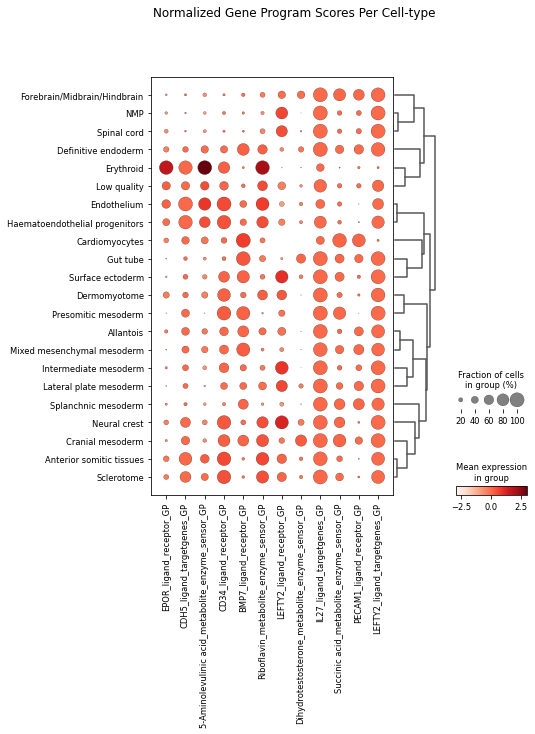

In [206]:
fig = sc.pl.dotplot(adata,
                    top_gps,
                    groupby=cell_type_key,
                    dendrogram=True, 
                    title="Normalized Gene Program Scores Per Cell-type",
                    return_fig=True)

# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/normalized_gp_scores_per_cell_type_{current_time}.png")
plt.show()

In [425]:
model.gp_key_ = "autotalker_combined_gp_names"

In [521]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                               gp_scores_weight_normalized=True,
                                               gp_scores_zi_normalized=True,
                                             adata=adata,
                                             comparison_cats="rest",
                                             n_sample=1000,
                                             selected_gps=["EPOR_ligand_receptor_GP", "BMP7_ligand_receptor_GP"],
                                             key_added=gp_enrichment_scores_key,
                                             n_top_up_gps_retrieved=n_top_up_gps,
                                             n_top_down_gps_retrieved=n_top_down_gps,
                                             seed=random_state)

In [478]:
# Compute gene program enrichments and retrieve top up- and downregulated gene programs
top_gps = model.compute_differential_gp_scores(cat_key=cell_type_key,
                                               gp_scores_weight_normalized=True,
                                               gp_scores_zi_normalized=True,
                                               adata=adata,
                                               comparison_cats="rest",
                                               n_sample=10,
                                               selected_gps="BMP7_ligand_receptor_GP",
                                               key_added=gp_enrichment_scores_key,
                                               n_top_up_gps_retrieved=n_top_up_gps,
                                               n_top_down_gps_retrieved=n_top_down_gps,
                                               seed=random_state)

(1, 1)
torch.Size([19416, 1])
torch.Size([19416, 1])


In [522]:
# Display top upregulated gene programs
adata.uns[gp_enrichment_scores_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,Erythroid,EPOR_ligand_receptor_GP,0.973300,0.026700,3.596020
1,Erythroid,BMP7_ligand_receptor_GP,0.795813,0.204187,1.360330
2,Endothelium,EPOR_ligand_receptor_GP,0.795678,0.204322,1.359496
3,Spinal cord,BMP7_ligand_receptor_GP,0.792618,0.207382,1.340778
4,Low quality,EPOR_ligand_receptor_GP,0.764608,0.235392,1.178109
5,NMP,BMP7_ligand_receptor_GP,0.733358,0.266642,1.011730
6,Haematoendothelial progenitors,EPOR_ligand_receptor_GP,0.712472,0.287528,0.907421
7,Anterior somitic tissues,BMP7_ligand_receptor_GP,0.680298,0.319702,0.755141
8,Forebrain/Midbrain/Hindbrain,BMP7_ligand_receptor_GP,0.676244,0.323756,0.736564
9,Low quality,BMP7_ligand_receptor_GP,0.666997,0.333003,0.694633


In [465]:
# Display top upregulated gene programs
adata.uns[gp_enrichment_scores_key]

,category,gene_program,p_h0,p_h1,log_bayes_factor
0,Spinal cord,BMP7_ligand_receptor_GP,0.762852,0.237148,1.168380
1,Low quality,BMP7_ligand_receptor_GP,0.731914,0.268086,1.004354
2,Erythroid,BMP7_ligand_receptor_GP,0.698569,0.301431,0.840492
3,Haematoendothelial progenitors,BMP7_ligand_receptor_GP,0.682633,0.317367,0.765898
4,NMP,BMP7_ligand_receptor_GP,0.671449,0.328551,0.714746
5,Intermediate mesoderm,BMP7_ligand_receptor_GP,0.597804,0.402196,0.396321
6,Dermomyotome,BMP7_ligand_receptor_GP,0.546345,0.453655,0.185912
7,Neural crest,BMP7_ligand_receptor_GP,0.509698,0.490302,0.038798
8,Cranial mesoderm,BMP7_ligand_receptor_GP,0.492108,0.507892,-0.031572
9,Endothelium,BMP7_ligand_receptor_GP,0.484906,0.515094,-0.060395


In [382]:
df = model.compute_gp_gene_importances(selected_gps="BMP7_ligand_receptor_GP",
                                       gp_key=gp_key)

-739.1735
(702, 1)


In [374]:
df

,gene_program,gene,gene_entity,weight_based_gene_importance
0,BMP7_ligand_receptor_GP,Bmp7,source,1.358805
1,BMP7_ligand_receptor_GP,Abcc4,target,0.000000
2,BMP7_ligand_receptor_GP,Gata1,source,-0.000000
3,BMP7_ligand_receptor_GP,Foxc2,source,-0.000000
4,BMP7_ligand_receptor_GP,Foxd4,source,0.000000
...,...,...,...,...
697,BMP7_ligand_receptor_GP,Pcdh19,target,0.000000
698,BMP7_ligand_receptor_GP,Pcgf2,target,0.000000
699,BMP7_ligand_receptor_GP,Pcgf3,target,0.000000
700,BMP7_ligand_receptor_GP,Zic3,source,-0.000000


In [353]:
df = model.compute_gp_gene_importances(gp_name="BMP7_ligand_receptor_GP",
                                       gp_key=gp_key)

In [354]:
df

,gene,gene_entity,weights_nb_means_normalized,weights_zi_prob_logits,weight_based_importance
0,Acvr1,target,1.358805,3.895674,1.449994
1,Bmp7,source,-0.035137,0.203298,0.050006


In [347]:
selected_gps = ["BMP7_ligand_receptor_GP"]
selected_cell_types = ["Cardiomyocytes"]
selected_genes = ["Acvr1"]

In [329]:
n_top_up_gps+n_top_down_gps*6

42

In [337]:
adata.obs["BMP7_ligand_receptor_GP"].sum()

134.80656306921844

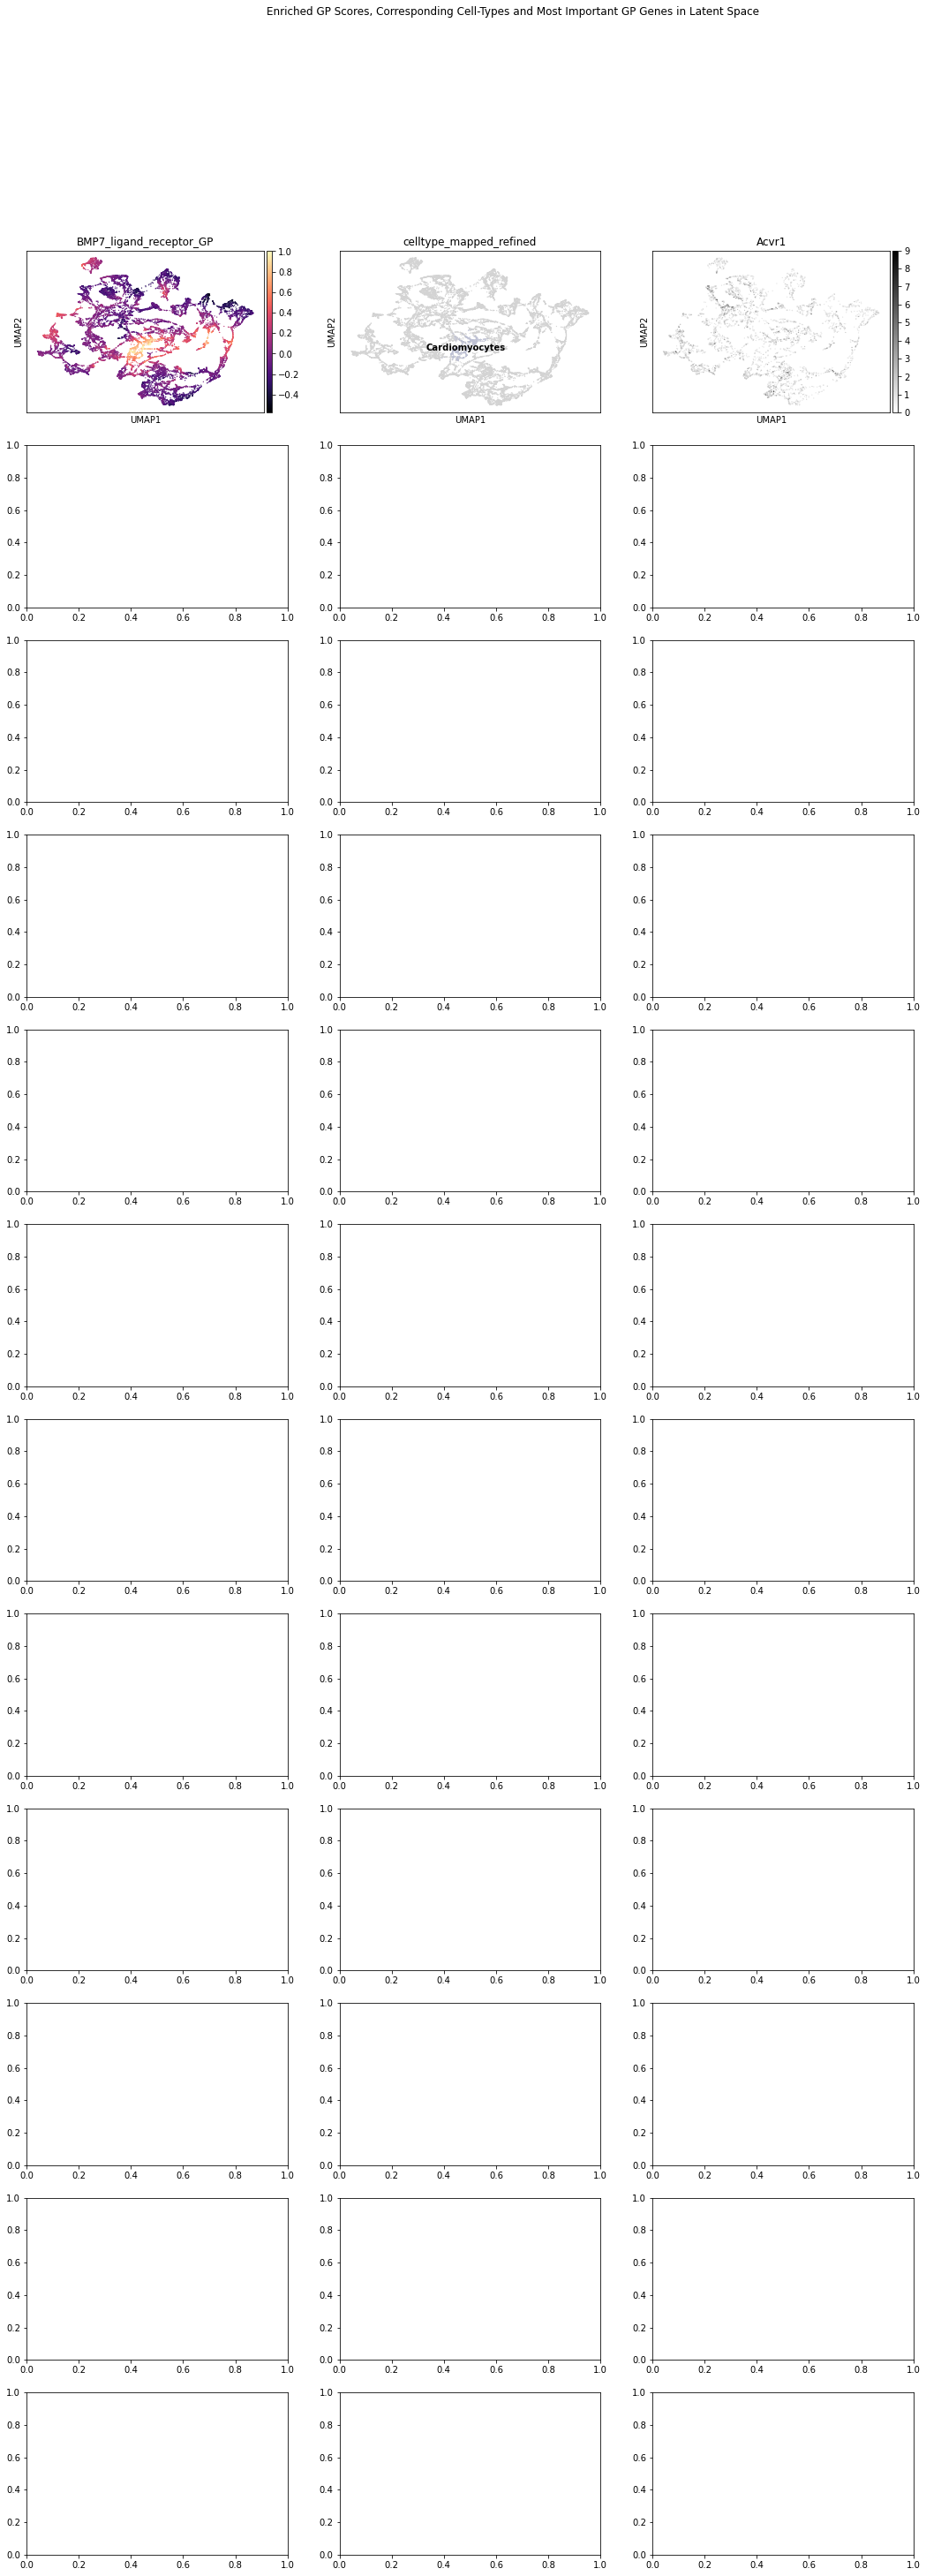

In [348]:
# Plot selected gene program latent scores
fig, axs = plt.subplots(nrows=n_top_up_gps+n_top_down_gps, ncols=3, figsize=(18,4*(n_top_up_gps+n_top_down_gps)))
title = fig.suptitle("Enriched GP Scores, Corresponding Cell-Types and Most Important GP Genes in Latent Space", x=0.55, y=0.96)
for i in range(len(selected_gps)):
    sc.pl.umap(adata, color=selected_gps[i], color_map="magma", ax=axs[i, 0], show=False)
    sc.pl.umap(adata,
               color=[cell_type_key],
               color_map="magma",
               groups=selected_cell_types[i],
               ax=axs[i, 1],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    sc.pl.umap(adata,
               color=selected_genes[i],
               color_map="binary",
               ax=axs[i, 2],
               legend_loc="on data",
               na_in_legend=False,
               show=False)
    
# Save and display plot
fig.savefig(f"figures/analysis/{dataset}/enriched_cell_type_gp_scores_and_most_important_genes_{current_time}.png",
            bbox_extra_artists=(title,),
            bbox_inches="tight")
plt.show()

In [164]:
# Split gene program enrichments per gene program type
cell_type_ligand_receptor_gp_enrichment_df = cell_type_gp_enrichment_df[
    adata.uns[gp_enrichment_scores_key]["gene_program"].str.contains("ligand_receptor")].reset_index()

cell_type_ligand_targetgene_gp_enrichment_df = cell_type_gp_enrichment_df[
    adata.uns[gp_enrichment_scores_key]["gene_program"].str.contains("ligand_targetgenes")].reset_index()

cell_type_metabolite_enzyme_sensor_gp_enrichment_df = cell_type_gp_enrichment_df[
    adata.uns[gp_enrichment_scores_key]["gene_program"].str.contains("metabolite_enzyme_sensor")].reset_index()

##### 6.3.1.2 Interrogate Specific GPs

In [ ]:
top_gps = model.compute_gp_enrichment_scores(cat_key=cell_type_key,
                                             gp_key=gp_key,
                                             adata=adata,
                                             comparison_cats="rest",
                                             n_sample=5000,
                                             selected_gps=["BMP7_ligand_receptor_GP"],
                                             key_added=gp_enrichment_scores_key,
                                             n_top_up_gps_retrieved=n_top_up_gps,
                                             n_top_down_gps_retrieved=n_top_down_gps)

In [ ]:
cell_type_ligand_receptor_gp_enrichment_df["category"]

In [ ]:
# Get latent scores of selected gene programs and add them to ´adata.obs´
gps = adata.uns[gp_key]
selected_gps = [cell_type_ligand_receptor_gp_enrichment_df["gene_program"][0],
                cell_type_ligand_targetgene_gp_enrichment_df["gene_program"][0],
                cell_type_metabolite_enzyme_sensor_gp_enrichment_df["gene_program"][0]]
selected_gps_idx = [gps.index(gp) for gp in selected_gps]
latent_selected_gps = latent[:, selected_gps_idx]
for i, gp in enumerate(selected_gps):
    adata.obs[gp] = latent_selected_gps[:, i]

In [ ]:
selected_cell_types = [cell_type_ligand_receptor_gp_enrichment_df["category"][0],
                       cell_type_ligand_targetgene_gp_enrichment_df["category"][0],
                       cell_type_metabolite_enzyme_sensor_gp_enrichment_df["category"][0]]

In [ ]:
selected_genes = []
for gp in selected_gps:
    selected_genes.append(
        model.compute_gp_gene_importances(gp_name=gp,
                                          gp_key=gp_key)["gene"][0])

In [ ]:
selected_gps = ["BMP7_ligand_receptor_GP"]
cell_type = "Cardiomyocytes"
top_gene = model.compute_gp_gene_importances(gp_name=selected_gps[0],
                                             gp_key=gp_key)["gene"][0]

selected_gps_idx = [gps.index(gp) for gp in selected_gps]
latent_selected_gps = latent[:, selected_gps_idx]
for i, gp in enumerate(selected_gps):
    adata.obs[gp] = latent_selected_gps[:, i]

In [ ]:
sc.pl.umap(adata, color=selected_gps[0], color_map="magma")
sc.pl.umap(adata,
           color=[cell_type_key],
           color_map="magma",
           groups=cell_type,
           legend_loc="on data",
           na_in_legend=False)
sc.pl.umap(adata,
           color=top_gene,
           color_map="binary",
           legend_loc="on data",
           na_in_legend=False)

In [ ]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

##### 6.1.2 Spatial Gene Program Enrichment Scores

In [ ]:
model.calculate_gp_enrichment_scores(cat_key=f"latent_leiden_{str(resolution)}",
                                     gp_key=gp_key,
                                     adata=adata,
                                     comparison_cats="rest",
                                     selected_gps=["WNT2B_ligand_receptor_GP", "PECAM1_ligand_receptor_GP"],
                                     n_sample=1000,
                                     key_added="autotalker_combined_gp_cell_type_gp_enrichment_scores")

In [ ]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"].head()

#### 6.3 Gene Program Gene Importances

In [ ]:
model.compute_gp_gene_importances(gp_name="BMP7_ligand_receptor_GP",
                                  gp_key=gp_key)

In [ ]:
adata.uns["autotalker_combined_gp_cell_type_gp_enrichment_scores"]